# **Title Extractor**
The goal of the project is to extract titles from lecture slides using facebook's Detectron2. In order to achieve that goal lecture slide sets were split into single files and transformed into images beforehand. In order to understand ever class, method and function refer to the [detectron2 documentation]("https://detectron2.readthedocs.io/en/latest"). Let's start!
First we will need to get all the necessary packages in order to install detectron2. The documentation specifies what is needed.

In [4]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install torch==1.7.0 torchvision==0.8.1 torchaudio==0.7.0
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 13.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=89f2a13d8823a2913e526196eaade59f56a7d166060b1fb791a3f33b2818a3ea
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.7MB 33.2MB/s 
     |████████████████████████████████| 7.6MB 28.0MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalle

In [5]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
     |████████████████████████████████| 6.3MB 1.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 112kB 23.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=f63ee205793e3ab1470b78bb272a67beebc0c98826e84593981dbf63d1cd60e5
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=8ab5fe682eb3c1d4067f6740d1e01f0444b21ff18f89df1696bf9a57e3a53a15
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built fvcore antlr4-python3-runtime


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Data
The dataset was annotated with the web application [makesense.ai]("https://www.makesense.ai/"). The only possible export format from the tool is XML. As the easiest way to import data to detectron2 is with the Coco format, the data was split into train, validation and test and then the XML annotation were transformed from XML to Coco with the [Voc2Coco]("https://github.com/yukkyo/voc2coco") script. In order to make the google colab script convenient to use, the data has been uploaded to a github respository.

In [2]:
# Get Data from github
!git clone https://github.com/kostapao/dlv_title_extractor.git

Cloning into 'dlv_title_extractor'...
remote: Enumerating objects: 1031, done.
remote: Counting objects: 100% (1031/1031), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 1031 (delta 564), reused 1030 (delta 563), pack-reused 0
Receiving objects: 100% (1031/1031), 111.94 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (564/564), done.
Checking out files: 100% (1506/1506), done.


In order to work with the data it first needs to be registered.

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "./dlv_title_extractor/data/train/coco_train_annotations.json", "./dlv_title_extractor/data/train/images")
MetadataCatalog.get("dataset_train").thing_classes = ["Title"]
register_coco_instances("dataset_val", {}, "./dlv_title_extractor/data/val/coco_val_annotations.json", "./dlv_title_extractor/data/val/images")
MetadataCatalog.get("dataset_val").thing_classes = ["Title"]
register_coco_instances("dataset_test", {}, "./dlv_title_extractor/data/test/coco_test_annotations.json", "./dlv_title_extractor/data/test/images")
MetadataCatalog.get("dataset_test").thing_classes = ["Title"]

#Get metadata
train_metadata = MetadataCatalog.get("dataset_train")
val_metadata = MetadataCatalog.get("dataset_val")
test_metadata = MetadataCatalog.get("dataset_test")

In order to check if the data has been loaded corractly we are randomly picking and image from the training dataset and visualize it with the annotation.

[06/24 07:40:02 d2.data.datasets.coco]: Loaded 342 images in COCO format from ./dlv_title_extractor/data/train/coco_train_annotations.json


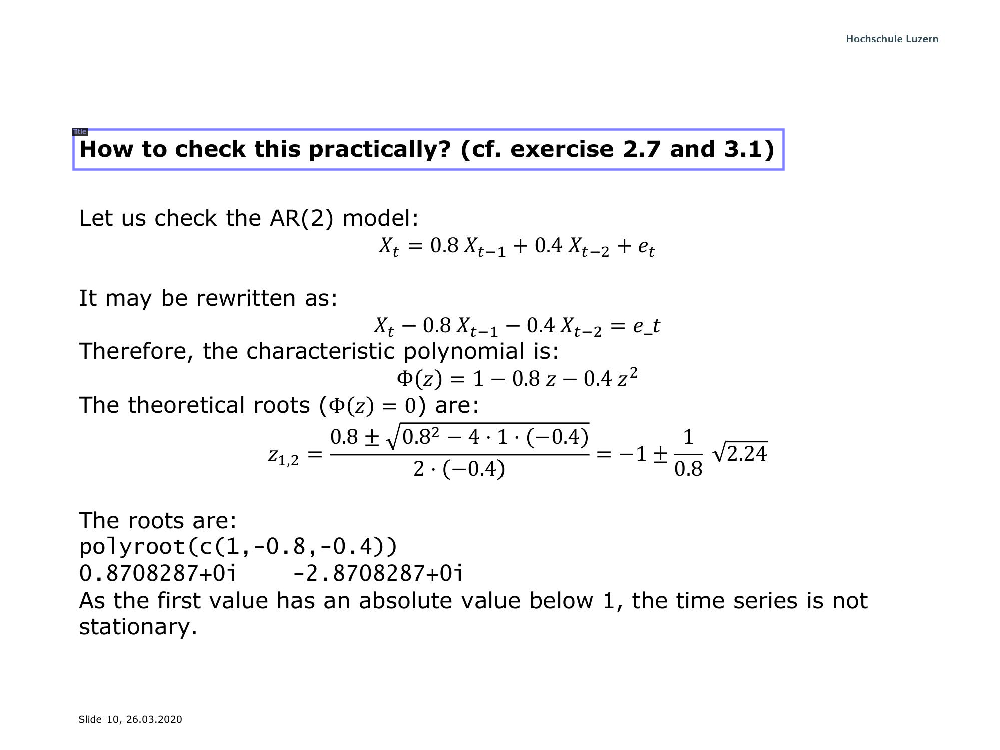

In [4]:
#Visualize training data
train_dataset_dicts = DatasetCatalog.get("dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])



## Prepare Custom Model Evaluator
The implemented Detectron2 evaluator does not provide the functionality to show the loss on the validation dataset during training. Luckily Marcelo Ortega has written a [script]("https://ortegatron.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e) for this:

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.logger import logging
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

## Model Configurations

In [32]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)

cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (title)


## Train Model

In [28]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/24 00:24:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[06/24 00:24:28 d2.engine.train_loop]: Starting training from iteration 0
[06/24 00:24:45 d2.utils.events]:  eta: 0:06:51  iter: 19  total_loss: 1.792  loss_cls: 0.7549  loss_box_reg: 0.001086  loss_rpn_cls: 0.9184  loss_rpn_loc: 0.08875  time: 0.8662  data_time: 0.0351  lr: 4.9953e-06  max_mem: 6237M
[06/24 00:25:03 d2.utils.events]:  eta: 0:06:34  iter: 39  total_loss: 1.712  loss_cls: 0.5826  loss_box_reg: 0.04797  loss_rpn_cls: 0.8509  loss_rpn_loc: 0.1225  time: 0.8766  data_time: 0.0052  lr: 9.9902e-06  max_mem: 6528M
[06/24 00:25:21 d2.utils.events]:  eta: 0:06:27  iter: 59  total_loss: 0.8067  loss_cls: 0.3977  loss_box_reg: 0.2202  loss_rpn_cls: 0.08285  loss_rpn_loc: 0.0611  time: 0.8761  data_time: 0.0055  lr: 1.4985e-05  max_mem: 6650M
[06/24 00:25:39 d2.utils.events]:  eta: 0:06:25  iter: 79  total_loss: 0.6972  loss_cls: 0.3271  loss_box_reg: 0.2668  loss_rpn_cls: 0.01741  loss_rpn_loc: 0.06182  time: 0.8900  data_time: 0.0060  lr: 1.998e-05  max_mem: 6650M
[06/24 00:25:5

Visualization of Loss on Training Data and Validation Loss in one plot


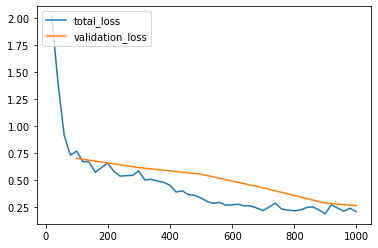

In [ ]:
import json
import matplotlib.pyplot as plt

project_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

project_metrics = load_json_arr(project_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in project_metrics if 'total_loss' in x],
    [x['total_loss'] for x in project_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in project_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in project_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

## Tensorboard

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Evaluation on Test Dataset

In [ ]:
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_test", cfg, False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "dataset_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

## Save Config File and Weights To Reuse Model
Create connection to google drive

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Copy files from google colab to google drive

In [ ]:
#Copy .pth and yml. to Drive
%cp /content/output/model_final.pth /content/gdrive/MyDrive
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()
%cp /content/config.yml /content/gdrive/MyDrive

## Load Trained Model

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Get weights and config file from google drive

In [2]:
#Copy .pth and yml. to Drive
%cp /content/gdrive/MyDrive/model_final.pth /content
%cp /content/gdrive/MyDrive/config.yml /content


# **DEMO**

## Visualisation of Predicted Boxes
Loop through 5 randomly selected test images and draw predicted boxes for titles.

In [67]:
#Visualisation of Inference on Test Data
test_dataset_dicts = DatasetCatalog.get("dataset_test")
from detectron2.utils.visualizer import Visualizer
cfg = get_cfg()
cfg.merge_from_file("/content/config.yml")
cfg.merge_from_list(["MODEL.WEIGHTS", "/content/model_final.pth"])
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.90
predictor = DefaultPredictor(cfg)



[06/24 09:08:37 d2.data.datasets.coco]: Loaded 73 images in COCO format from ./dlv_title_extractor/data/test/coco_test_annotations.json


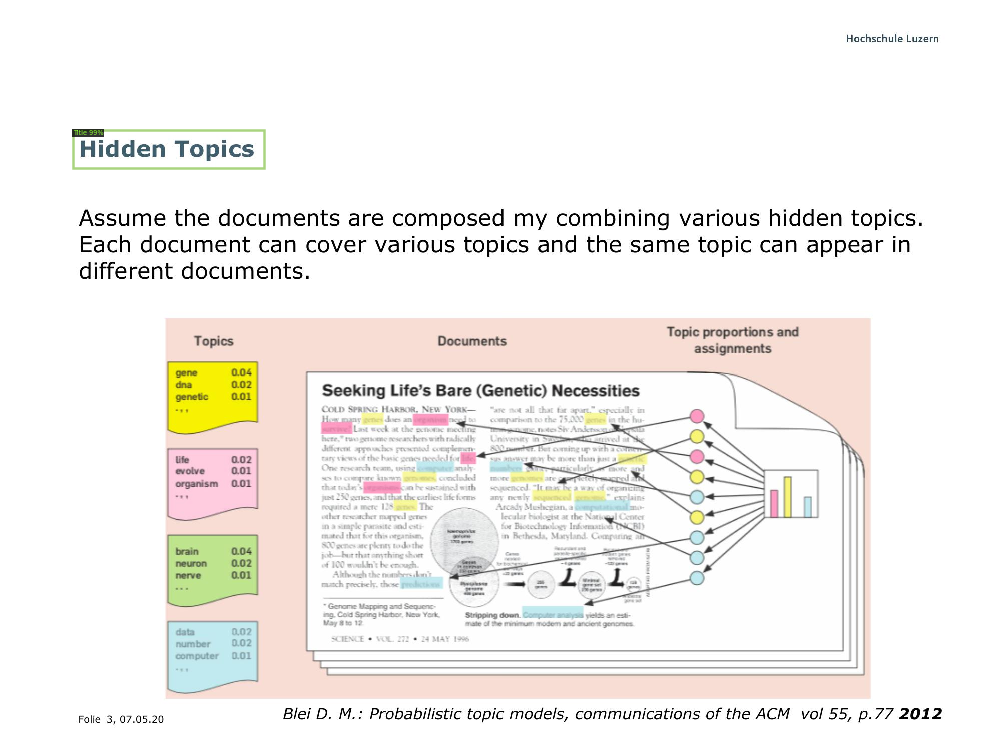

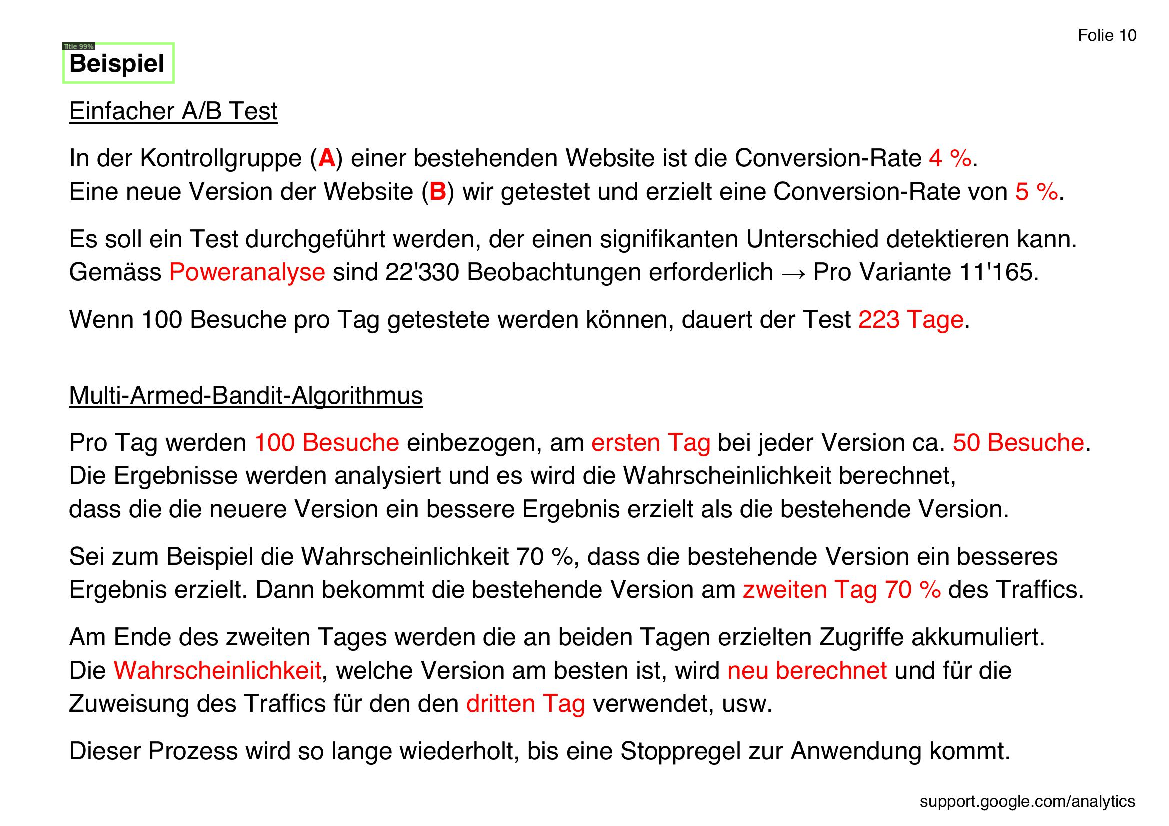

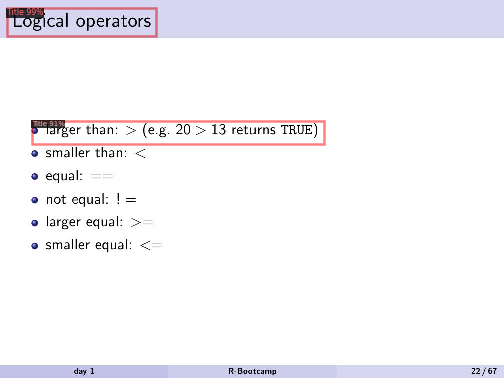

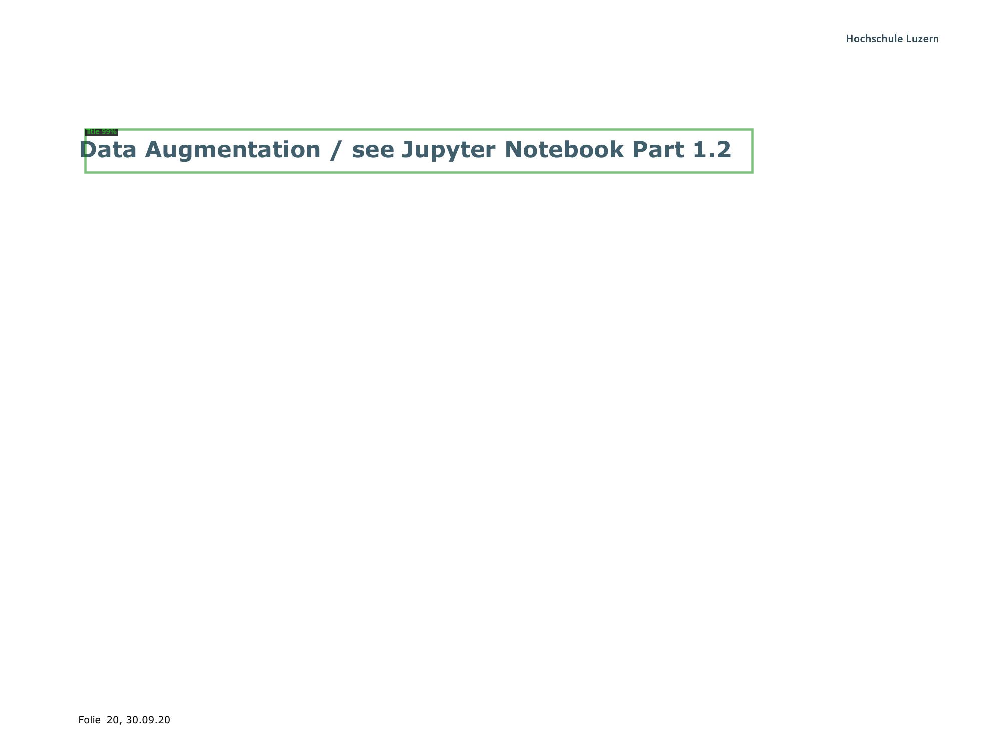

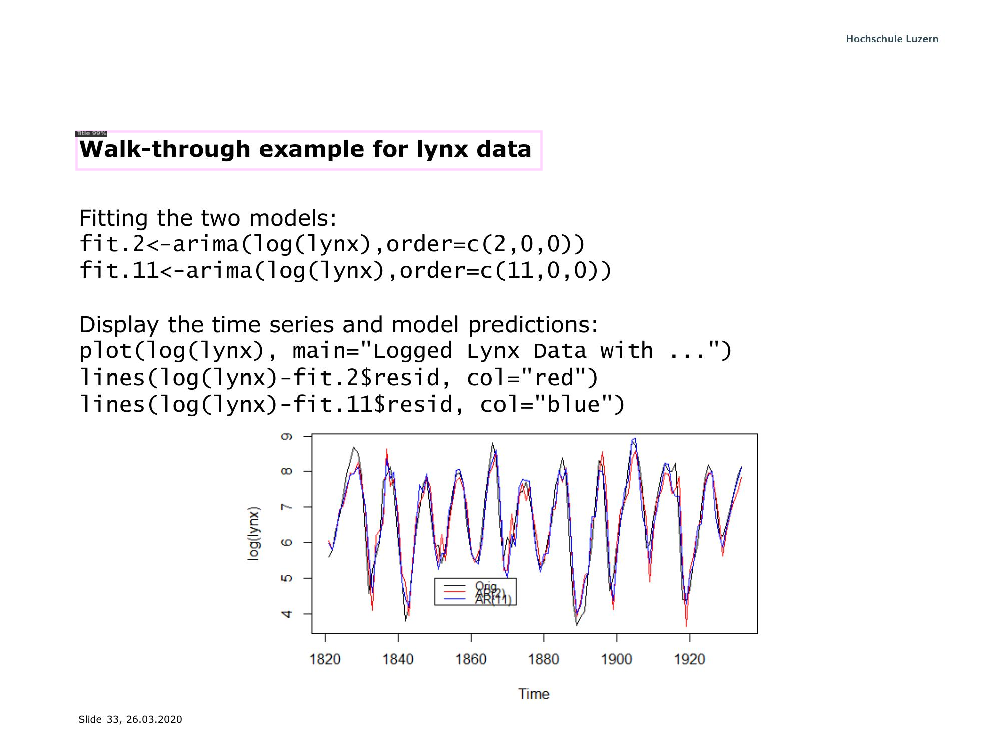

In [68]:
for d in random.sample(test_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

## Extract Title: Object Detection + OCR

In [49]:
#Install Tesseract For OCR
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


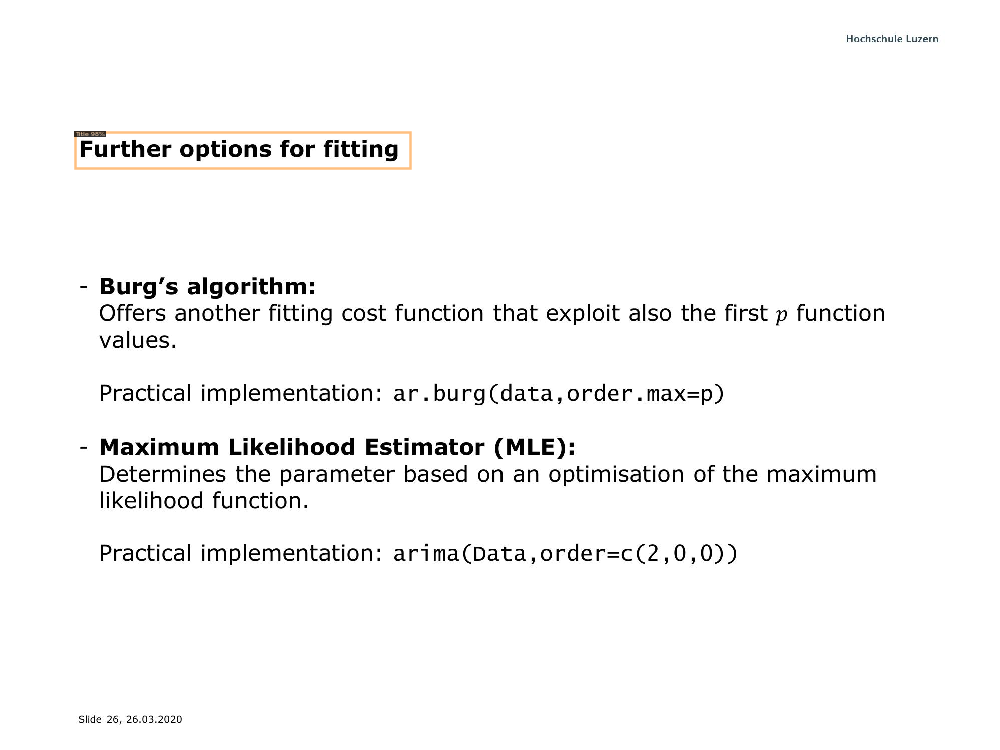

In [69]:
from detectron2 import structures
file_path = "/content/dlv_title_extractor/data/test/images/page100.jpg"
im = cv2.imread(file_path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
              metadata=test_metadata, 
                scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

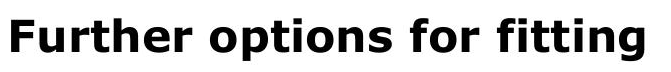

In [70]:
#Get The Predicted box
pred_box = outputs["instances"].get_fields()["pred_boxes"].tensor.cpu().numpy().tolist()[0]
left_upper_x = pred_box[0]
left_upper_y = pred_box[1]
box_width = pred_box[2]
box_height = pred_box[3]
#print(height, width,left_upper_y, left_upper_x, box_width,box_height )
img = Image.open(file_path)
im1 = img.crop((left_upper_x, left_upper_y, box_width, box_height))
im1

In [71]:
title = pytesseract.image_to_string(im1)
print(title)


Further options for fitting

